In [17]:
!pip install --quiet arbor networkx numpy pandas python-catmaid


In [18]:
#!/usr/bin/env python3
import time
from pathlib import Path

import arbor as arb
import data_preparation as dp
from arbor_recipes import basic_recipe
import networkx as nx
import numpy as np
import os

# -----------------------
# 1. Load neuron ids from complete_graph(3k).gml
# -----------------------

# Adjust to the real path on the cluster:
# graph_path = Path("/content/drive/MyDrive/connectomics/Drosophila-Larvae-Simulation/Datasets/Neurons Metadata/Graphs/complete_graph(3k).gml")
# g = nx.read_gml(graph_path)

neuron_ids = ['7055857', '1805418', '14260575', '5835799', '10160250', '7840203', '5019924', '13986477', '10167078', '7982896', '4119387', '17591442', '4227544', '10495502', '8069478', '3913629', '11279244', '16846805', '8980589', '3664102']
neuron_ids = [int(i) for i in neuron_ids]

# assuming node labels are neuron ids (strings of ints)
neuron_ids = sorted(neuron_ids)

print(f"Loaded complete graph with {len(neuron_ids)} neurons")
print(neuron_ids)


Loaded complete graph with 20 neurons
[1805418, 3664102, 3913629, 4119387, 4227544, 5019924, 5835799, 7055857, 7840203, 7982896, 8069478, 8980589, 10160250, 10167078, 10495502, 11279244, 13986477, 14260575, 16846805, 17591442]


In [19]:

# -----------------------
# 2. Build your simulation_context
# -----------------------

# Adjust to your actual data directory with morphologies & metadata
data_root = Path("sample_data/data")

Sctx = dp.simulation_context(str(data_root), neuron_ids)


In [20]:

# -----------------------
# 3. Hardware context: GPU + MPI
# -----------------------
print(arb.__version__)
print(arb.config())
# Use all available threads on each rank and GPU 0.
# You can also control threads via ARBENV_NUM_THREADS env var.
ctx = arb.context(threads=1)
print("Context:", ctx)


0.11.0
{'mpi': False, 'mpi4py': False, 'gpu': None, 'vectorize': False, 'profiling': False, 'neuroml': True, 'bundled': False, 'version': '0.11.0', 'source': 'unknown commit', 'build_config': 'RELEASE', 'arch': 'native', 'prefix': '/tmp/tmpwd14aixs/wheel/platlib/arbor', 'python_lib_path': '', 'binary_path': 'bin', 'lib_path': 'lib64', 'data_path': 'share', 'CXX': '/opt/rh/gcc-toolset-14/root/usr/bin/g++', 'pybind-version': '2.13.6', 'timestamp': 'Apr 24 2025 18:06:18'}
Context: <arbor.context: num_threads 1, has_gpu False, has_mpi False, num_ranks 1>


In [22]:

# -----------------------
# 4. Meter manager for profiling Arbor time
# -----------------------

meters = arb.meter_manager()
meters.start(ctx)

# -----------------------
# 5. Recipe: HH everywhere, expsyn as alpha-like synapse
# -----------------------
#neurite_df = pd.read_csv("path/to/neurites_params.csv")
recipe = basic_recipe(
    Sctx,
    record_soma=True,
    nodes_to_record=None,   # or list of node_ids if you want dendrites too
    iclamp_schedule=None,   # NO input current, as required
    cable_type="hh",
    synapce_type="expsyn"   # or "exp2syn" if you prefer bi-exponential
    #neurite_params=neurite_df,
)
meters.checkpoint("recipe-create", ctx)


In [23]:

# -----------------------
# 6. Domain decomposition with GPU hint
# -----------------------

hint = arb.partition_hint()
hint.prefer_gpu = True
hint.gpu_group_size = 1000  # typical value from Arbor GPU tutorial
hints = {arb.cell_kind.cable: hint}

decomp = arb.partition_load_balance(recipe, ctx, hints)
meters.checkpoint("load-balance", ctx)


In [24]:

# -----------------------
# 7. Simulation setup
# -----------------------

sim = arb.simulation(recipe, ctx, decomp)
sim.record(arb.spike_recording.all)

dt = 0.01 * arb.units.ms
schedule = arb.regular_schedule(dt)

# sample soma of *all* cells every 0.1 ms
soma_handles = [
    sim.sample((gid, "soma"), schedule)
    for gid in range(recipe.num_cells())
]

meters.checkpoint("simulation-init", ctx)


19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [ ]:

# -----------------------
# 8. Run 1 second of biological time and measure wall-clock
# -----------------------

t0 = time.perf_counter()
sim.run(tfinal=1000 * arb.units.ms, dt=dt)  # 1 s, max step 0.1 ms
t1 = time.perf_counter()
meters.checkpoint("simulation-run", ctx)


In [ ]:

# -----------------------
# 9. Report timing and dump a few traces
# -----------------------

# Use context.rank to only print once in MPI runs
if ctx.rank == 0:
    print(f"Wall-clock time (Python time.perf_counter): {t1 - t0:.3f} s")
    print(arb.meter_report(meters, ctx))

    # Save first few soma traces to CSV for plotting later
    os.makedirs("results", exist_ok=True)
    n_to_save = recipe.num_cells()

    for gid in range(n_to_save):
        # Each handle corresponds to 1 probe ("soma") → samples[0]
        samples = sim.samples(soma_handles[gid])
        data = samples[0][0]  # numpy array: [t, U]
        np.savetxt(
            f"results/soma_gid{gid}.csv",
            data,
            delimiter=",",
            header="t(ms),U(mV)",
            comments=""
        )

    print(f"Saved soma traces for gids 0..{n_to_save-1} in results/")


Wall-clock time (Python time.perf_counter): 142.370 s

---- meters -------------------------------------------------------------------------------
meter                         time(s)      memory(MB)
-------------------------------------------------------------------------------------------
recipe-create                  50.968          24.048
load-balance                    0.017          -0.296
simulation-init                19.267           5.372
simulation-run                142.379          41.981
meter-total                   212.631          71.104

Saved soma traces for gids 0..19 in results/


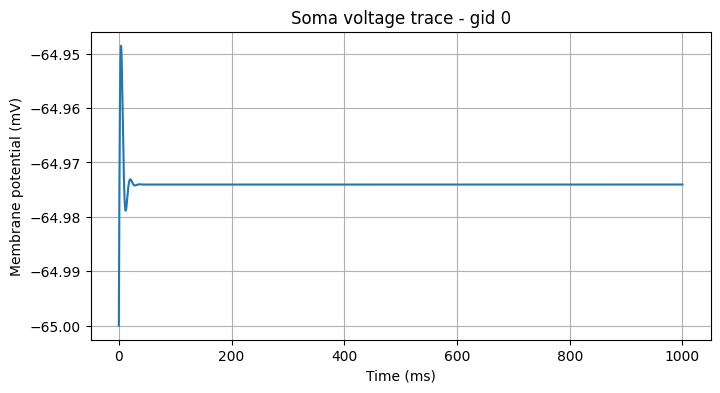

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("results/soma_gid0.csv", delimiter=",", skiprows=1)
t = data[:, 0]   # time in ms
U = data[:, 1]   # voltage in mV

plt.figure(figsize=(8, 4))
plt.plot(t, U)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.title("Soma voltage trace - gid 0")
plt.grid(True)
plt.show()


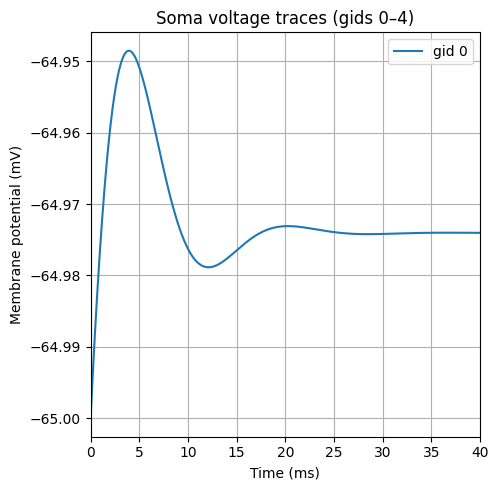

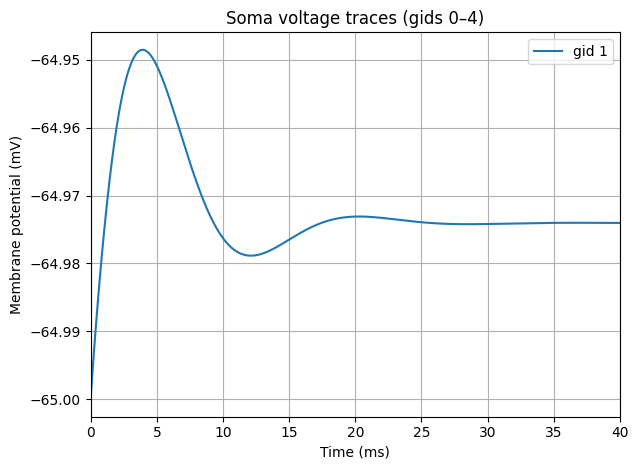

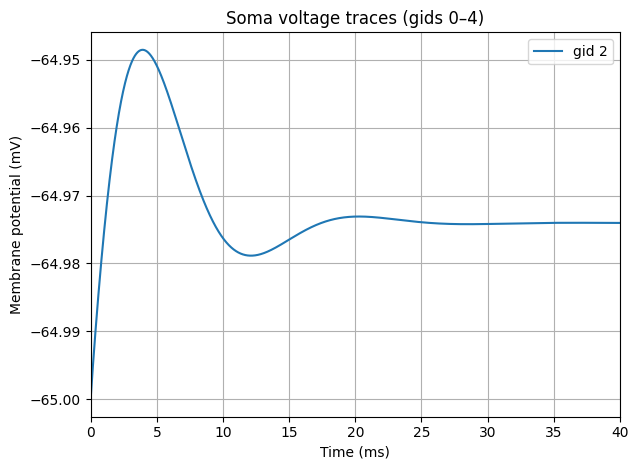

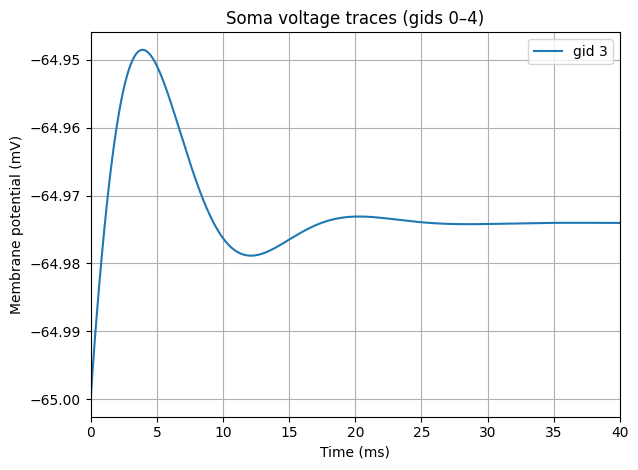

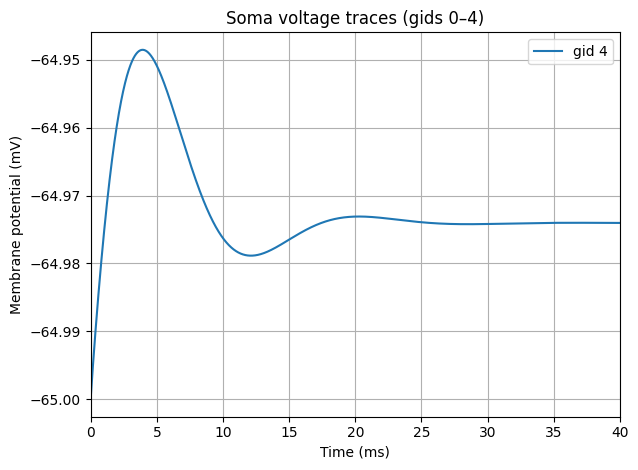

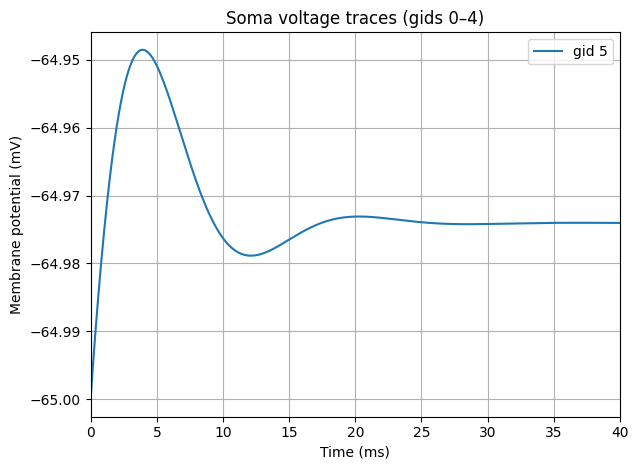

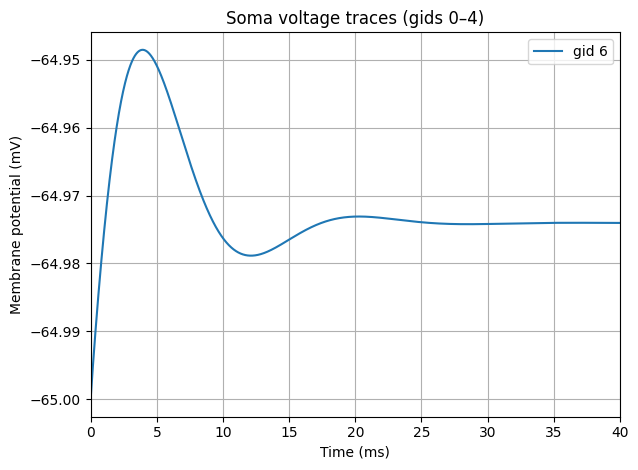

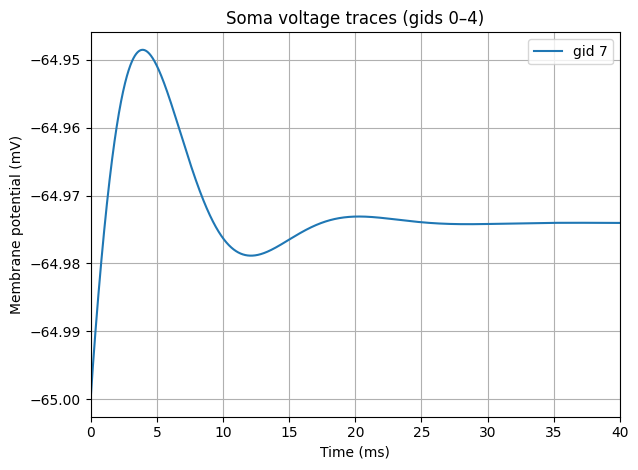

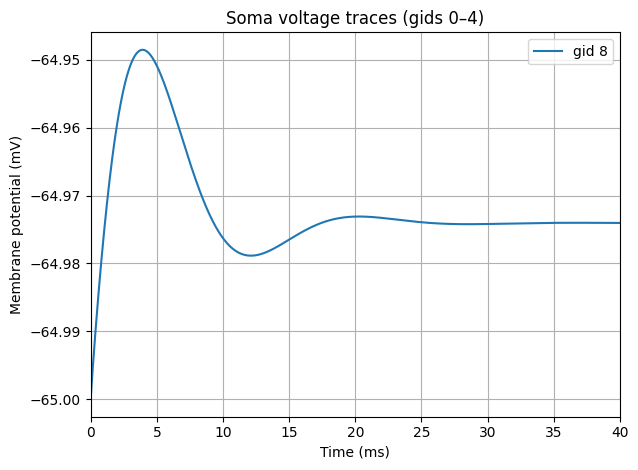

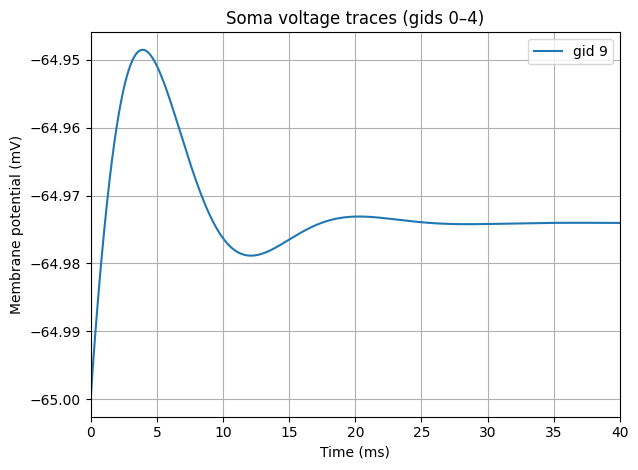

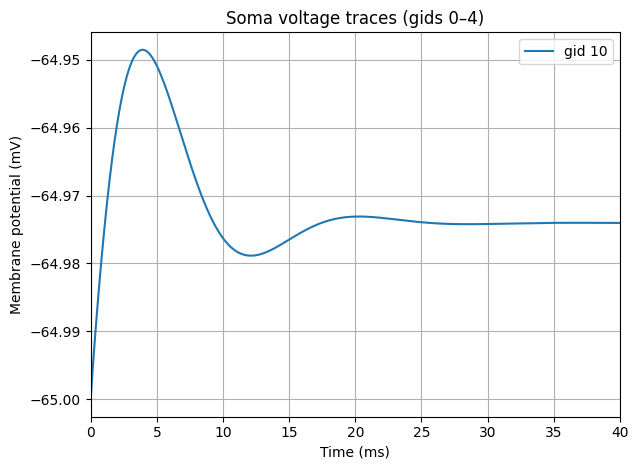

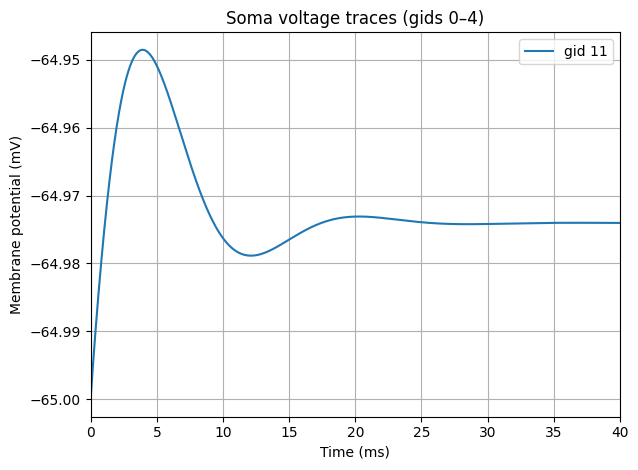

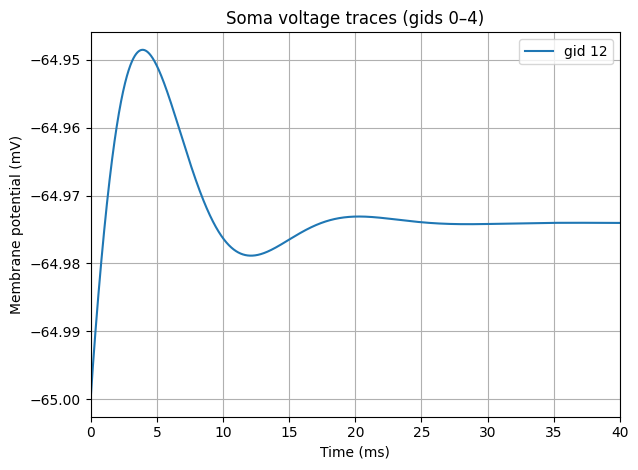

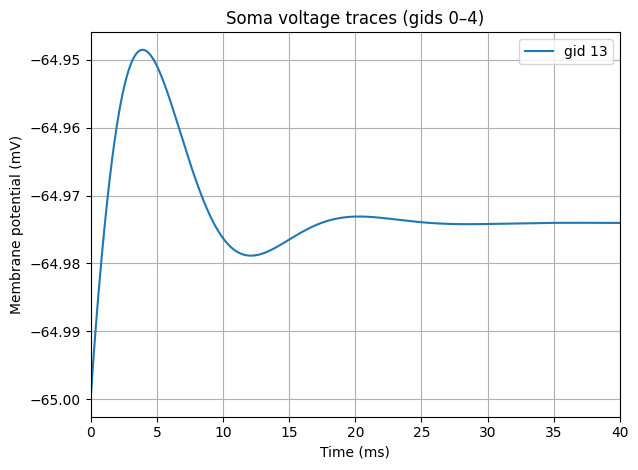

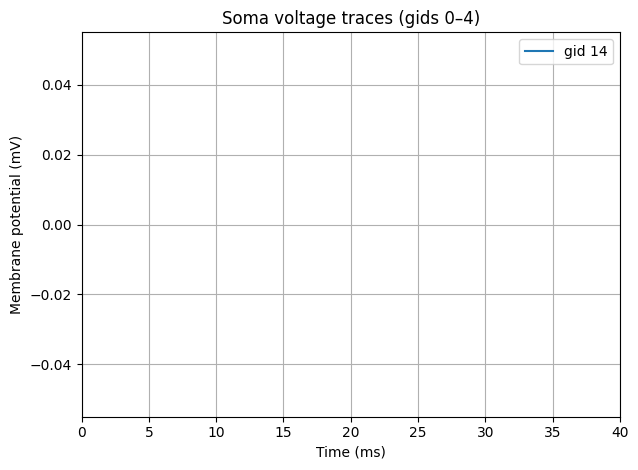

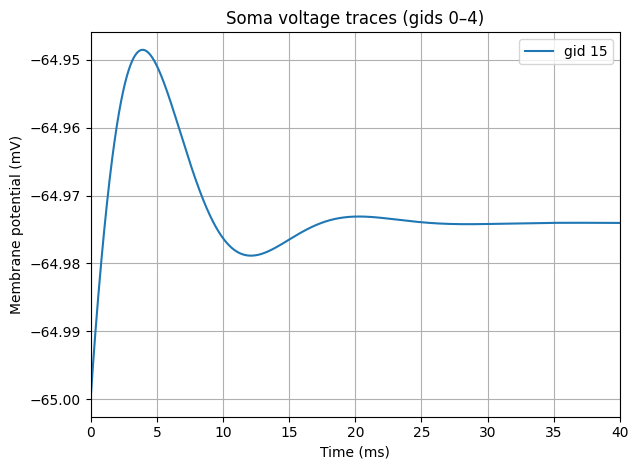

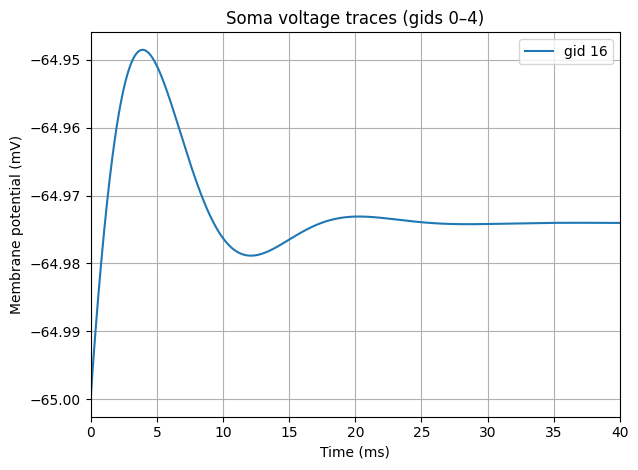

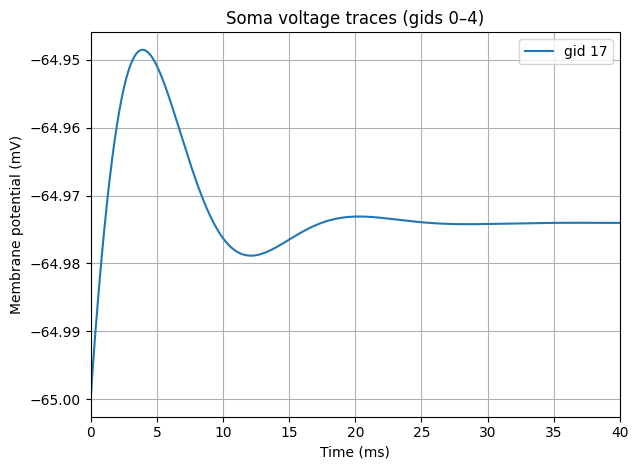

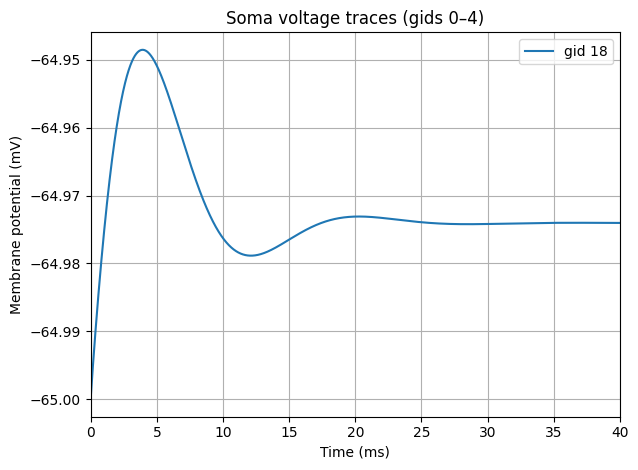

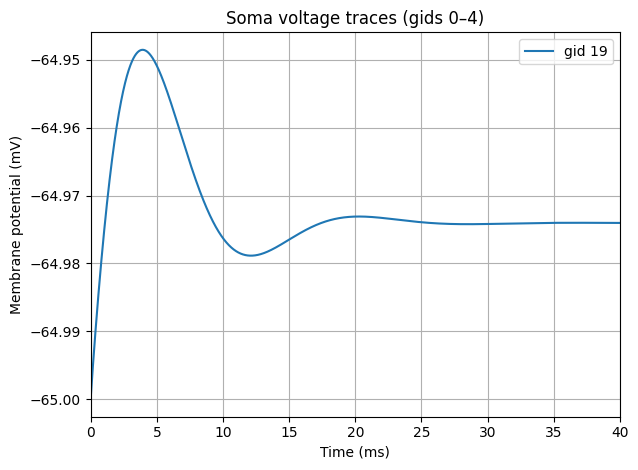

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

for gid in range(n_to_save):  # 0..4, since you saved 5 traces
    data = np.loadtxt(f"results/soma_gid{gid}.csv", delimiter=",", skiprows=1)
    t = data[:, 0]
    U = data[:, 1]
    plt.plot(t, U, label=f"gid {gid}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane potential (mV)")
    plt.title("Soma voltage traces (gids 0–4)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(0, 40)   # 🔹 only show 0–20 ms
    plt.grid(True)
    plt.show()


